<div class="sc-eZkcaX hQBQJi"><div class="note">
We highly recommend <a href="https://kaggle.com/c/titanic/overview">Titanic - Machine Learning from Disaster</a> to get familiar with the basics of machine learning and Kaggle competitions.
</div>
<p>Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.</p>
<p>The <em>Spaceship Titanic</em> was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.</p>
<p>While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary <em>Spaceship Titanic</em> collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!</p>
<p><img style="float:center;height:320px;width:404px" src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg"></p>
<p>To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.</p>
<p>Help save them and change history!</p>


# Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

<div class="sc-kFuwyI fXnIZt"><div style="min-height: 80px;"><div class="sc-eZkcaX hQBQJi"><p>In this competition your task is to predict whether a passenger was transported to an alternate dimension during the <em>Spaceship Titanic</em>'s collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.</p>
<h1>File and Data Field Descriptions</h1>
<ul>
<li><strong>train.csv</strong> - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.<ul>
<li><code>PassengerId</code> - A unique Id for each passenger. Each Id takes the form <code>gggg_pp</code> where <code>gggg</code> indicates a group the passenger is travelling with and <code>pp</code> is their number within the group. People in a group are often family members, but not always.</li>
<li><code>HomePlanet</code> - The planet the passenger departed from, typically their planet of permanent residence.</li>
<li><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
<li><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form <code>deck/num/side</code>, where <code>side</code> can be either <code>P</code> for <em>Port</em> or <code>S</code> for <em>Starboard</em>.</li>
<li><code>Destination</code> - The planet the passenger will be debarking to.</li>
<li><code>Age</code> - The age of the passenger.</li>
<li><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</li>
<li><code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code> - Amount the passenger has billed at each of the <em>Spaceship Titanic</em>'s many luxury amenities.</li>
<li><code>Name</code> - The first and last names of the passenger.</li>
<li><code>Transported</code> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</li></ul></li>
<li><strong>test.csv</strong> - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of <code>Transported</code> for the passengers in this set. </li>
<li><strong>sample_submission.csv</strong> - A submission file in the correct format.<ul>
<li><code>PassengerId</code> - Id for each passenger in the test set.</li>
<li><code>Transported</code> - The target. For each passenger, predict either <code>True</code> or <code>False</code>.</li></ul></li>
</ul></div></div></div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder
#from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

In [2]:
# Load data
full_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Analyze data

In [3]:
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Separate test_df PassengerId (will need it for submission)
test_pass_id = test_df.PassengerId.copy()

# Keep max index that will be used to back split training and test data
X_max_index = full_df.shape[0]

# Separate features and target
y = full_df.Transported.astype(int)

df = full_df.drop(['Transported'], axis=1).copy()
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


# Unprocessed data correlation

In [5]:
full_df.corr()['Transported'].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

# Features' instances

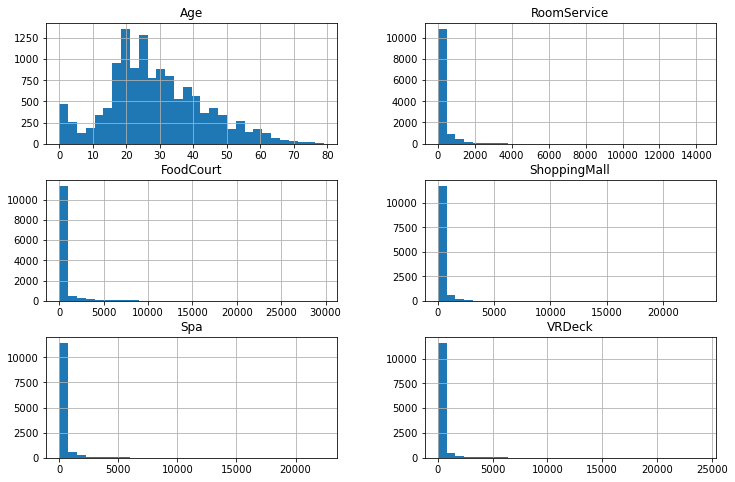

In [6]:
df.hist(bins=30, figsize=(12, 8))
plt.show()

# Process data

In [7]:
# Split passenger group into separate feature
df['Pass_group'] = df.PassengerId.str.split('_').str[0]
df.Pass_group = df.Pass_group.astype(float)

# Split Lastname into separate feature
df['Lastname'] = df.Name.str.split(' ').str[1]

# Split Cabin into 3 separate features
df[['Deck', 'Cab_num', 'Deck_side']] = df.Cabin.str.split('/', expand=True)
df.Cab_num = df.Cab_num.astype(float)

# Dealing with the outliers

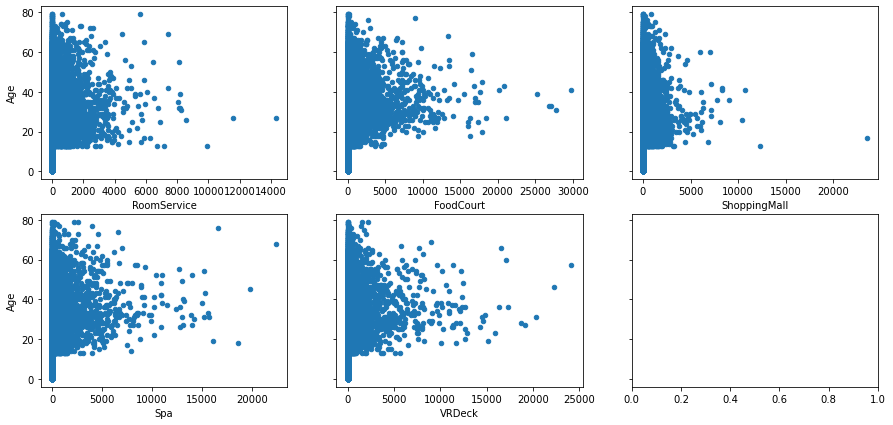

In [8]:
# Looking for outliers
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

In [9]:
# Cap RoomService at 9000
df.loc[df.RoomService.gt(9000), 'RoomService'] = 9000

# Cap FoodCourt at 22000
df.loc[df.FoodCourt.gt(22000), 'FoodCourt'] = 22000

# Cap ShoppingMall at 11000
df.loc[df.ShoppingMall.gt(11000), 'ShoppingMall'] = 11000

# Cap Spa at 17000
df.loc[df.Spa.gt(17000), 'Spa'] = 17000

# Cap VRDeck at 21000
df.loc[df.VRDeck.gt(21000), 'VRDeck'] = 21000

# Run previous cell again to visualize the result

# Impute amenities

In [10]:
# Check if the passengers in CryoSleep have always zero values for amenities
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df.loc[df.CryoSleep.eq(True), amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [11]:
# For passengers in CryoSleep we impute zero for missing amenities values
df.loc[df.CryoSleep.eq(True), amenities] = 0

# Where summ of amenities is 0 we also impute 0 for missing values
zero_amenities = df[amenities].sum(axis=1).eq(0)
df.loc[zero_amenities, amenities] = 0

# Impute median for values greater than 0 for each amenities column where passengers are not in CryoSleep
for i in amenities: 
    df.loc[df[i].isna(), i] = df.loc[df[i].gt(0), i].median()

# Create Total_expenses

In [12]:
# We will calculate the total expenses the passenger had on amenities
df['Total_expenses'] = df[amenities].sum(axis=1)

# Impute CryoSleep

In [13]:
# Impute CryoSleep = False where Total_expenses are greater than 0
df.loc[(df.CryoSleep.isna() & df.Total_expenses.gt(0)), 'CryoSleep'] = False

# Impute VIP

In [14]:
# Check the minimum Age for passengers with VIP status
df.groupby('VIP').Age.min()

VIP
False     0.0
True     18.0
Name: Age, dtype: float64

Underage passengers don't have VIP status

In [15]:
# Check VIPs by HomePlanet and Destination
df.groupby(['HomePlanet', 'Destination']).VIP.value_counts()

HomePlanet  Destination    VIP  
Earth       55 Cancri e    False     956
            PSO J318.5-22  False    1043
            TRAPPIST-1e    False    4568
Europa      55 Cancri e    False    1195
                           True       83
            PSO J318.5-22  False      16
                           True       13
            TRAPPIST-1e    False    1618
                           True       78
Mars        55 Cancri e    False     290
            PSO J318.5-22  False      55
                           True        9
            TRAPPIST-1e    False    2122
                           True       81
Name: VIP, dtype: int64

- There are a lot of passengers from Earth, but no VIPs
- There are no VIPs between passengers from Mars that goes to Cancri 
- VIPs going to Cancri are just from Europa

In [16]:
# Impute VIP = False for underage passengers
df.loc[(df.VIP.isna() & (df.Age < 18)), 'VIP'] = False

In [17]:
# Impute VIP = False for passengers from Earth
df.loc[(df.VIP.isna() & (df.HomePlanet == 'Earth')), 'VIP'] = False

# Impute VIP = False for passengers from Mars that goes to Cancri
df.loc[(df.VIP.isna() 
        & (df.HomePlanet.eq('Mars'))
        & (df.Destination.eq('55 Cancri e'))), 'VIP'] = False

In [18]:
# Check VIPs and CryoSleep by Deck
df.groupby(['VIP', 'CryoSleep']).Deck.value_counts()

VIP    CryoSleep  Deck
False  False      F       3309
                  G       1701
                  E       1023
                  C        561
                  D        500
                  B        464
                  A        204
                  T         10
       True       G       2018
                  F        837
                  B        581
                  C        442
                  E        249
                  D        164
                  A         92
True   False      B         48
                  C         45
                  F         41
                  A         40
                  D         38
                  E         26
       True       B         10
                  C         10
                  A          5
                  D          3
Name: Deck, dtype: int64

- There are no VIPs on decks G and T
- VIPs in CryoSleep are just on the decks A to D

In [19]:
# Impute VIP = False for passengers on deck G and T
df.loc[(df.VIP.isna() 
        & (df.Deck.isin(['G', 'T']))), 'VIP'] = False

# Impute VIP = True for passengers that are not on decks A to D and not in CryoSleep
df.loc[df.VIP.isna() 
       & df.CryoSleep.eq(False) 
       & ~df.Deck.isin(['A', 'B', 'C', 'D']), 'VIP'] = True

# Impute HomePlanet

In [20]:
# From previous analysis VIPs going to Cancri are just from Europa
df.loc[(df.HomePlanet.isna() 
        & df.VIP.eq(True) 
        & df.Destination.eq('55 Cancri e')), 'HomePlanet'] = 'Europa'

In [21]:
# Check if all the passengers from the same group have departed from the same HomePlanet
df.groupby('Pass_group').HomePlanet.nunique().gt(1).sum()

0

In [22]:
# Create a Pass_group-HomePlanet dictionary
present_values = ~df.Pass_group.isna() & ~df.HomePlanet.isna()
group_home_map = (df.loc[present_values, ['Pass_group', 'HomePlanet']]
            .set_index('Pass_group').to_dict()['HomePlanet'])

# Impute HomePlanet from dictionary
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Pass_group.map(group_home_map)

In [23]:
# Analyse HomePlanet-Deck distribution
df.groupby('HomePlanet').Deck.value_counts()

HomePlanet  Deck
Earth       G       3731
            F       2437
            E        589
Europa      B       1137
            C       1096
            A        352
            D        302
            E        199
            T         10
            F          1
Mars        F       1742
            E        515
            D        410
Name: Deck, dtype: int64

- Decks T, A, B, C are just from Europa
- Deck G is just from Earth


In [24]:
# Impute HomePlanet based on previous distribution analysis
df.loc[(df.HomePlanet.isna() 
        & df.Deck.isin(['T', 'A', 'B', 'C',])), 'HomePlanet'] = 'Europa'

df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

In [25]:
# Check if all the passengers with the same Lastname have departed from the same HomePlanet
df.groupby('Lastname').HomePlanet.nunique().gt(1).sum()

1

In [26]:
# Create a Lastname-HomePlanet dictionary
present_values = ~df.Lastname.isna() & ~df.HomePlanet.isna()
lastname_home_map = (df.loc[present_values, ['Lastname', 'HomePlanet']]
            .set_index('Lastname').to_dict()['HomePlanet'])

# Impute HomePlanet from dictionary
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Lastname.map(lastname_home_map)

# Impute Age

In [27]:
# Impute median Age for people with VIP status
df.loc[((df.VIP == True) & df.Age.isna()), 'Age'] = df.loc[(df.VIP == True), 'Age'].median()

# Impute median Age for people that have expenses
df.loc[(df.Age.isna() 
        & df.Total_expenses.gt(0)), 'Age'] = df.loc[df.Total_expenses.gt(0), 'Age'].median()

# Impute median Age for people with no expenses and not in CryoSleep
df.loc[(df.Age.isna() 
        & df.Total_expenses.eq(0)
        & df.CryoSleep.eq(False)), 'Age'] = df.loc[(df.Total_expenses.eq(0) 
                                                    & df.CryoSleep.eq(False)), 'Age'].median()

# Impute an overall median Age for people not included in previous groups
df.Age.fillna(df.Age.median(), inplace=True)

# Impute Cab_num

In [28]:
df.Cab_num.fillna(df.Cab_num.median(), inplace=True)

# Create Group_members

In [29]:
# We count the number of passengers in each group
Group_members = df.Pass_group.value_counts().to_dict()
df['Group_members'] = df.Pass_group.map(Group_members)

# Create Cabin_members

In [30]:
# We count the number of members in each cabin
Cabin_members = df.Cabin.value_counts().to_dict()
df['Cabin_members'] = df.Cabin.map(Cabin_members)

# Impute mean for missing cabin
df.Cabin_members.fillna(df.Cabin_members.mean(), inplace=True)

# Create Deck_transp_ratio

In [31]:
# Create full data frame for analysis
X = df[:X_max_index]
test_df = df[X_max_index:]
full_df = pd.concat([X, y], axis=1).copy()

# Total passengers by Deck
deck_total_pass = full_df.groupby('Deck').Deck.count()

# Total Transported by Deck
deck_total_transported = full_df.groupby('Deck').Transported.sum()

# Dictionary with Deck_transp_ratio
Deck_transp_ratio = (deck_total_transported / deck_total_pass).to_dict()

# Create Deck_transp_ratio
df['Deck_transp_ratio'] = df.Deck.map(Deck_transp_ratio)
df.Deck_transp_ratio.fillna(df.Deck_transp_ratio.mean(), inplace=True)

# Create Deck_side_transp_ratio

In [32]:
# Total passengers by Deck_side
deck_side_total = full_df.groupby('Deck_side').Deck.count()

# Total Transported by Deck_side
deck_side_transported = full_df.groupby('Deck_side').Transported.sum()

# Dictionary with Deck_side_transp_ratio
Deck_side_transp_ratio = (deck_side_transported / deck_side_total).to_dict()

# Create Deck_side_transp_ratio
df['Deck_side_transp_ratio'] = df.Deck_side.map(Deck_side_transp_ratio)
df.Deck_side_transp_ratio.fillna(df.Deck_side_transp_ratio.mean(), inplace=True)

In [33]:
# Drop further unused columns
col_drop = ['PassengerId', 'Cabin', 'Name', 'Lastname']
df = df.drop(col_drop, axis=1)

# Impute and encode categorical features

In [34]:
# List of categorical columns
categ_cols = list(df.select_dtypes(['object', 'category']).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]), 
                      columns=df[categ_cols].columns)

# Encode categoricals
df_cat = pd.get_dummies(df_cat)

# Impute numericals

In [35]:
# List of numerical columns
num_cols = list(df.select_dtypes(['int64', 'float64']).columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df[num_cols]], axis=1)

# Impute numericals
it_imp = IterativeImputer()
df = pd.DataFrame(it_imp.fit_transform(df), columns=df.columns)

# Feature engineering

In [36]:
# Create a full data frame for analysis
X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)
full_df['Non_zero_expenses'] = full_df.loc[full_df.Total_expenses.gt(0), 'Total_expenses']

In [37]:
# Function for kde plotting
def transported_chance_by(feature, xticks=None, xlim=None):
    transported = full_df[full_df.Transported == 1]
    not_transported = full_df[full_df.Transported == 0]

    plt.figure(figsize=(10, 5))

    transported[feature].plot(kind='kde', label='transported')
    not_transported[feature].plot(kind='kde', label='not_transported')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

# Create Age_group feature

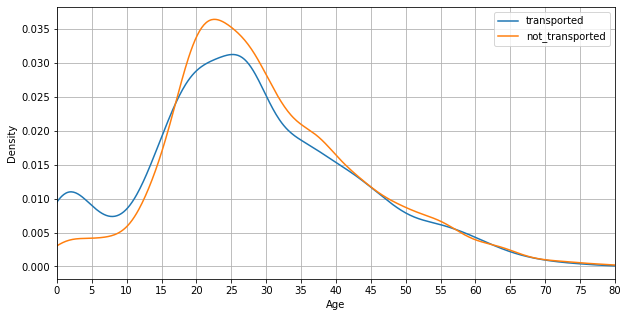

In [38]:
# Transported by Age
transported_chance_by('Age', np.arange(0, 81, 5), (0, 80))

By curves intersection points we can separate 3 age groups

In [39]:
# Create Age_group feature
df['Age_group'] = pd.cut(x=df.Age, labels=[1, 3, 2],
                         bins=[-1, 17, 43, df.Age.max()]).astype('float')

# Create Total_expenses_group feature

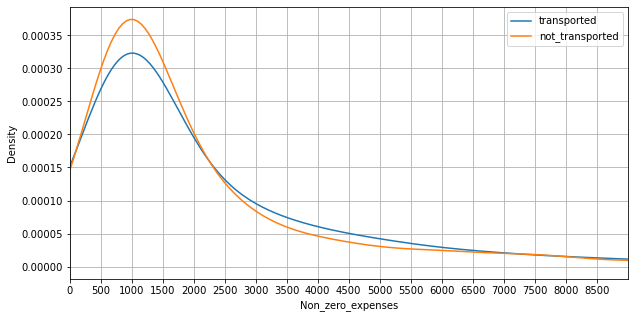

In [40]:
# Transported by Non_zero_expenses
transported_chance_by('Non_zero_expenses', np.arange(0, 9000, 500), (0, 9000))

By curves intersection points we can separate 2 Total_expenses groups

In [41]:
# Create Total_expenses_group feature additionally separating 0 expenses group
df['Total_expenses_group'] = pd.cut(x=df.Total_expenses, labels=[3, 1, 2],
                         bins=[-1, 1, 2250, df.Total_expenses.max()]).astype('float')

# Create Cab_group feature

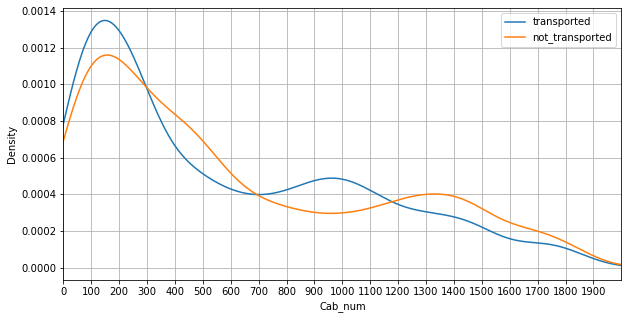

In [42]:
# Transported by Cab_num
transported_chance_by('Cab_num', np.arange(0, 2000, 100), (0, 2000))

By curves intersection points we can separate 4 cabin groups

In [43]:
# Create Cab_group feature
df['Cab_group'] = pd.cut(x=df.Cab_num, labels=[3, 2, 4, 1],
                         bins=[-1, 300, 690, 1170, df.Cab_num.max()]).astype('float')

# Create Pass_group_type feature

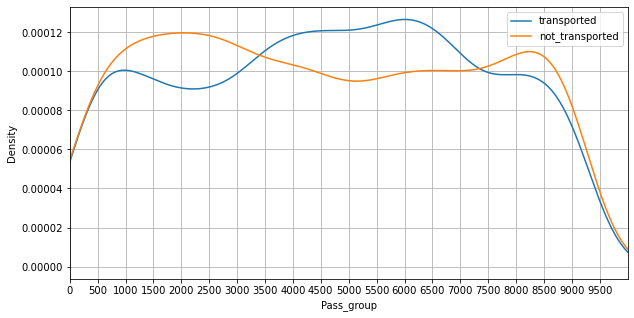

In [44]:
# Transported by Pass_group
transported_chance_by('Pass_group', np.arange(0, 10000, 500), (0, 10000))

By curves intersection points we can separate 3 passengers group type

In [45]:
# Create Pass_group_type feature
df['Pass_group_type'] = pd.cut(x=df.Pass_group, labels=[2, 3, 1], 
                               bins=[-1, 3400, 7300, df.Pass_group.max()]).astype('float')

# Standardization

In [46]:
# Apply np.log to normalize the skewed right data
skewed_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 
                   'Spa', 'VRDeck', 'Total_expenses']
df[skewed_features] = df[skewed_features].apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [47]:
# Drop columns not used for modeling
col_drop = ['Cab_num', 'Pass_group']
df = df.drop(col_drop, axis=1)

# Split train and test data

In [48]:
X = df[:X_max_index]
test_df = df[X_max_index:]

# Processed data correlation

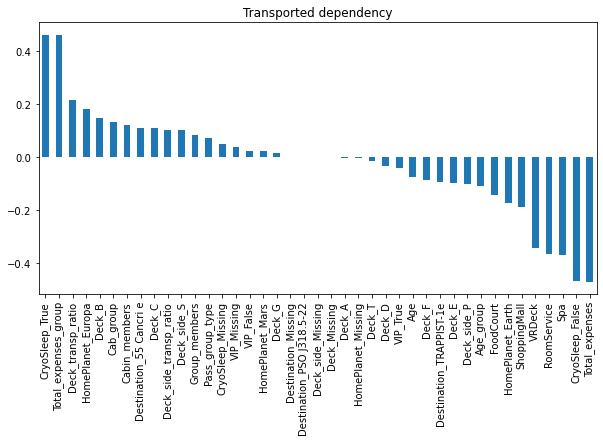

In [49]:
# Concatenate into a full dataset
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Transported'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Transported dependency')
plt.show()

# Conclusion
On Spaceship Titanic is better to not be a sleeping passenger from Europa or to be awake with an all inclusive package with no extra expenses.

# Find best features
This cell is commented out as it takes long time to run and the resulted final_features are shown further

In [50]:
# # Define model
# cat_model = CatBoostClassifier(thread_count=-1, verbose=False)

# # Define and fit feature selector
# sfs = SequentialFeatureSelector(cat_model, 
#                                 scoring='accuracy', 
#                                 direction = 'backward')
# sfs.fit(X,y)

# # List of the final features to be used for submission modeling
# final_features = list(sfs.get_feature_names_out())

In [51]:
# From Feature selector we've got this list of final features to use
final_features = [
    'HomePlanet_Earth', 'HomePlanet_Mars', 'HomePlanet_Missing', 'CryoSleep_True',
    'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_Missing',
    'Deck_T', 'Deck_side_P', 'Age', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck',
    'Total_expenses', 'Group_members', 'Deck_transp_ratio', 'Total_expenses_group', 'Cab_group']

# CatBoost grid search parameter tuning
This cell is commented out as it takes long time to run and the resulted parameters are shown further

In [52]:
# # Define model
cat_model = CatBoostClassifier()

# Define parameters' grid
grid = {'verbose': [False],
         'thread_count': [-1],
         'depth': [4, 5, 6, 7],
         'iterations': [1000, 2000,2500,2700,3000,3200,3800,5000],
         'learning_rate': [0.001,0.004,0.0045, 0.005,0.0055, 0.01, 0.02]}

# # Define GridSearchCV
#
grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
# 
grid_cat.fit(X[final_features], y)

# 
params = grid_cat.best_params_

# 
print('\n Best Score:\n', grid_cat.best_score_)
# 
print('\n Best parameters:\n', params)


 Best Score:
 0.8147948835166497

 Best parameters:
 {'depth': 5, 'iterations': 3800, 'learning_rate': 0.005, 'thread_count': -1, 'verbose': False}


In [53]:
# Best parameters
params =  {'depth': 6,
           'iterations': 2000, 
           'learning_rate': 0.01, 
           'thread_count': -1, 
           'verbose': False}

# Final model

In [54]:
# Define and fit the final model
cat_model = CatBoostClassifier(**grid_cat.best_params_)
cat_model.fit(X[final_features], y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X[final_features], y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

count    5.000000
mean     0.820432
std      0.019031
min      0.801610
25%      0.808400
50%      0.811386
75%      0.834388
max      0.846375
dtype: float64

                    Feature Id  Importances
0           Deck_transp_ratio    14.986643
1                         Spa    11.864934
2              Total_expenses    11.683020
3                      VRDeck    10.314285
4            HomePlanet_Earth     8.320324
5                 RoomService     7.836406
6        Total_expenses_group     6.126846
7                 Deck_side_P     5.458912
8                   Cab_group     5.224130
9                         Age     4.753066
10            HomePlanet_Mars     3.848547
11               ShoppingMall     2.839611
12             CryoSleep_True     2.476837
13    Destination_TRAPPIST-1e     2.051503
14              Group_members     1.414391
15  Destination_PSO J318.5-22     0.342915
16                     Deck_A     0.311524
17               Deck_Missing     0.138002
18         HomePlanet_

<h1 style="color:red">RITARTHA:</h1>

In [55]:
from sklearn.ensemble import RandomForestClassifier as rfc
r = rfc()
r.fit(X[final_features], y)

RandomForestClassifier()

In [56]:
test_preds = r.predict(test_df[final_features])

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': test_preds.astype(bool)})

output.to_csv('submission17_03_23.csv', index=False)

# Submission


In [62]:
# Make predictions which we will submit.
test_preds = cat_model.predict(test_df[final_features])

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': test_preds.astype(bool)})

output.to_csv('submission.csv', index=False)